# UM results: external forcing runs

In [1]:
import iris
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
from iris.experimental import stratify
from matplotlib.offsetbox import AnchoredText

In [2]:
from tqdm.notebook import tqdm

In [3]:
import aeolus
from aeolus.calc import spatial_mean, time_mean, zonal_mean
from aeolus.const import init_const
from aeolus.coord import (
    get_cube_rel_days,
    get_xy_coords,
    isel,
    regrid_3d,
    replace_z_coord,
    roll_cube_pm180,
)
from aeolus.core import AtmoSim
from aeolus.io import create_dummy_cube, load_vert_lev
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units
from aeolus.subset import extract_last_n_days

In [4]:
import pouch
from pouch.clim_diag import calc_derived_cubes
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_SYM0,
    KW_ZERO_LINE,
    figsave,
    linspace_pm1,
    use_style,
)

KW_SYM0 = {**KW_SYM0, "cmap": "seismic"}

import paths
import quickplot as qplt

In [5]:
plt.style.use("custom.mplstyle")
pouch.RUNTIME.figsave_stamp = False

In [6]:
%load_ext watermark

%watermark
%watermark -iv

Last updated: 2022-11-04T17:38:09.449073+00:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 4.15.0-194-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 192
Architecture: 64bit

aeolus    : 0.4.15+14.g02f78ce
matplotlib: 3.6.1
numpy     : 1.23.4
pouch     : 0.0.dev0
iris      : 3.3.0



In [7]:
def load_raw_um_data(sim_label, subdir=""):
    fnames = sorted((paths.results_raw_um / sim_label / subdir).glob("atmos*/*a.p*"))
    return iris.load(fnames)


def load_proc_um_data(sim_label):
    fnames = sorted((paths.results_proc_um / sim_label).glob(f"{sim_label}*.nc"))
    with iris.FUTURE.context(datum_support=True):
        dset = iris.load(fnames)
    return dset

In [8]:
SIM_CASES = {
    "hs": {
        "title": "Held-Suarez",
        "short_title": "HS",
        "planet": "earth",
        "kw_plt": {"color": "C0"},
        "timestep": 1200,
    },
    "el": {
        "title": "Earth-like",
        "short_title": "EL",
        "planet": "earth",
        "kw_plt": {"color": "C1"},
        "timestep": 1200,
    },
    "tle": {
        "title": "Tidally Locked Earth",
        "short_title": "TLE",
        "planet": "earth",
        "kw_plt": {"color": "C2"},
        "timestep": 1200,
    },
}

MODELS = {
    "um": {
        "title": "UM",
        "get_files": load_proc_um_data,
        "kw_plt": {"linestyle": "--", "linewidth": 0.75, "dash_capstyle": "round"},
    },
    # "lfric": {"title": "LFRic", "get_files": load_lfric_data, "kw_plt": {"linestyle": "-"}},
}

In [9]:
# height_theta, height_rho = the_run.extract("height_above_reference_ellipsoid")
height_theta = np.linspace(0, 32000, 33)
height_rho = np.linspace(1000, 32000, 32) - 500

In [10]:
runs = {}
for model_key, model_prop in MODELS.items():
    runs[model_key] = {}

    for sim_label, sim_prop in SIM_CASES.items():
        cl = model_prop["get_files"](sim_label)
        const = init_const(sim_prop["planet"])
        calc_derived_cubes(cl, const=const)
        runs[model_key][sim_label] = AtmoSim(
            cl,
            name=sim_label,
            vert_coord="z",
            planet=sim_prop["planet"],
            const_dir=paths.const,
        )
        np.testing.assert_allclose(
            height_theta, runs[model_key][sim_label].coord.z.points
        )

## Zonal mean cross-sections

In [12]:
the_run = runs[model_key][sim_label]

In [14]:
DIAGS = {
    "temp": {
        "recipe": lambda AS: spatial_mean(isel(AS.temp, um.z, 0)),
        "name": "Air Temperature | Level 0",
        "tex_units": "$K$",
        # "lim": [5, 8],
    },
}

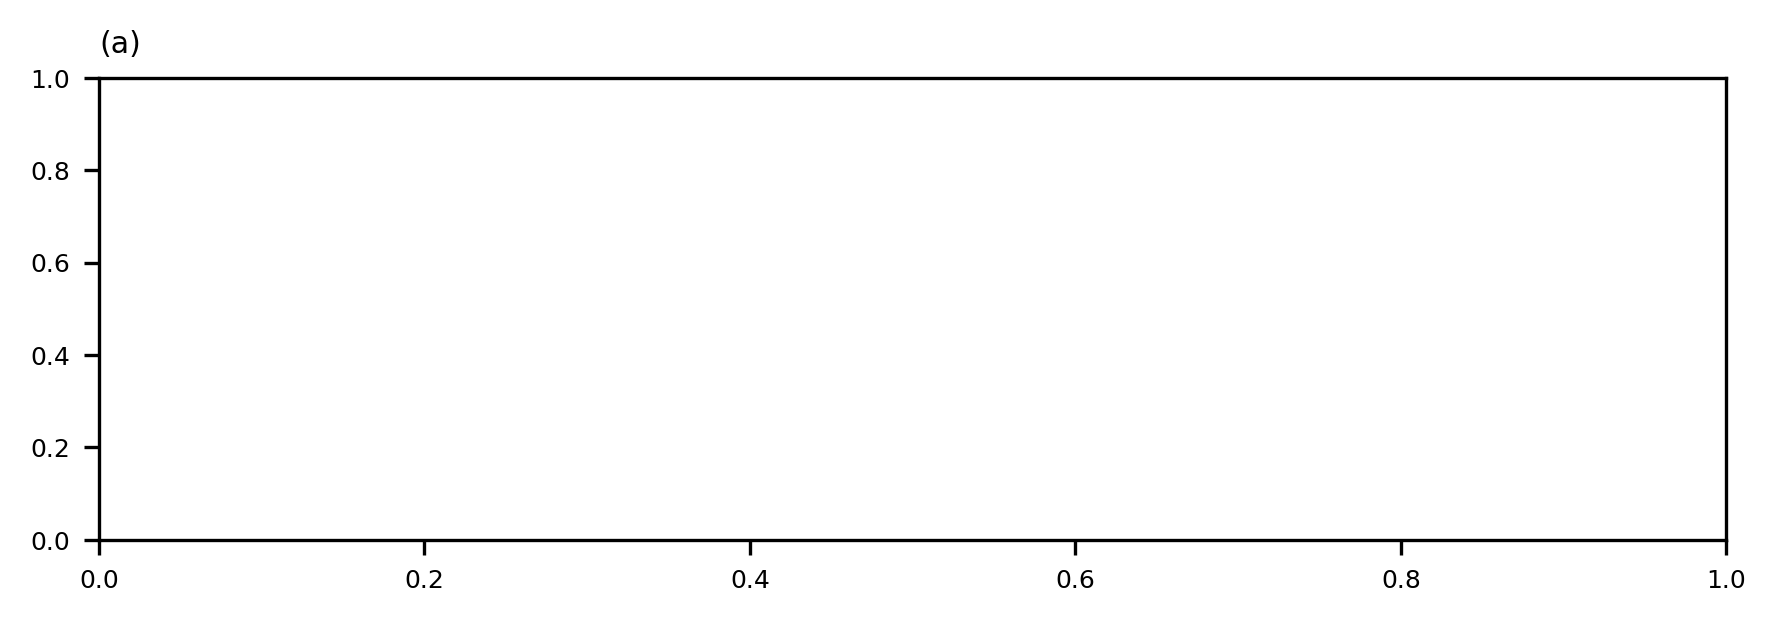

In [15]:
fig = plt.figure(figsize=(7, 2))
axd = fig.subplot_mosaic([DIAGS.keys()], gridspec_kw={"wspace": 0.45}, sharex=True)
iletters = subplot_label_generator()
for ax in axd.values():
    ax.set_title(f"({next(iletters)})", loc="left")

model_key = "um"
model_prop = MODELS[model_key]

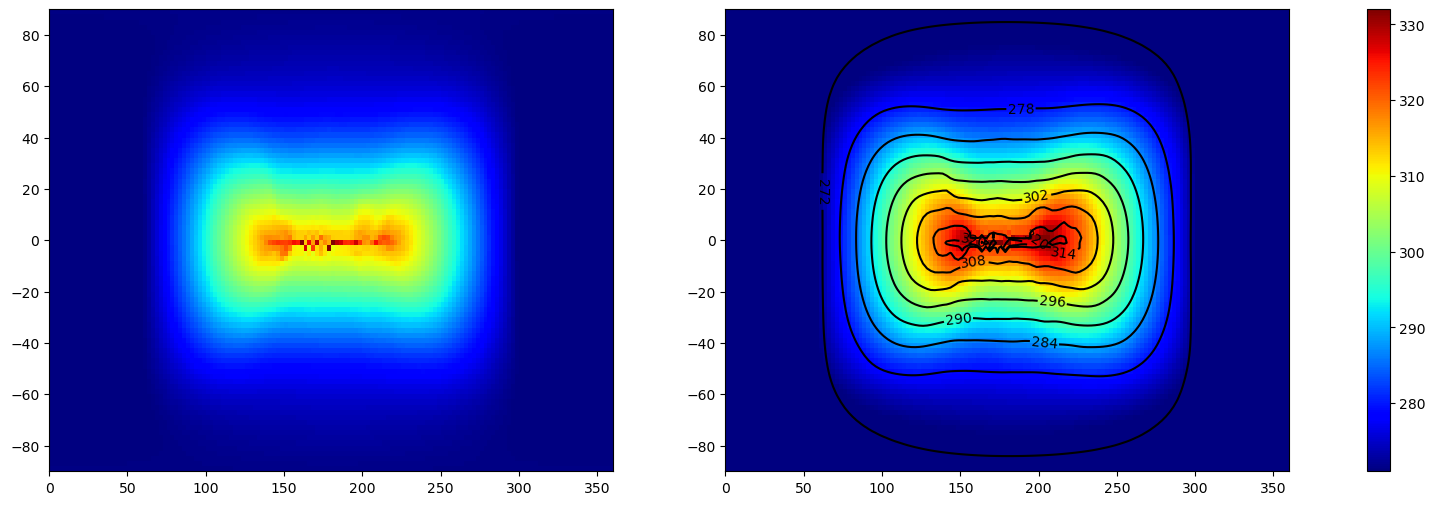

In [24]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=2)
pcol0 = axs[0].pcolormesh(
    lons, lats, theta[0, 0, ...].data, vmin=271, vmax=332, cmap=plt.cm.jet
)
pcol1 = axs[1].pcolormesh(
    lons, lats, theta[-1, 0, ...].data, vmin=271, vmax=332, cmap=plt.cm.jet
)
cntr = axs[1].contour(
    lons, lats, theta[0, 0, ...].data, colors="k", levels=np.arange(272, 321, 6)
)
axs[1].clabel(cntr, fmt="%.0f")

fig.colorbar(pcol0, ax=axs)

## Time series

In [12]:
DIAGS = {
    "temp_lev00": {
        "recipe": lambda AS: spatial_mean(isel(AS.temp, um.z, 0)),
        "name": "Air Temperature | Level 0",
        "tex_units": "$K$",
        # "lim": [5, 8],
    },
    "p_sfc": {
        "recipe": lambda AS: spatial_mean(AS.p_sfc),
        "name": "Surface Pressure",
        "tex_units": "$hPa$",
        # "lim": [0, 1.5],
    },
}

Saved to ../figures/exernal_forcing_um_hs_el_tle_temp_lev00_p_sfc.pdf


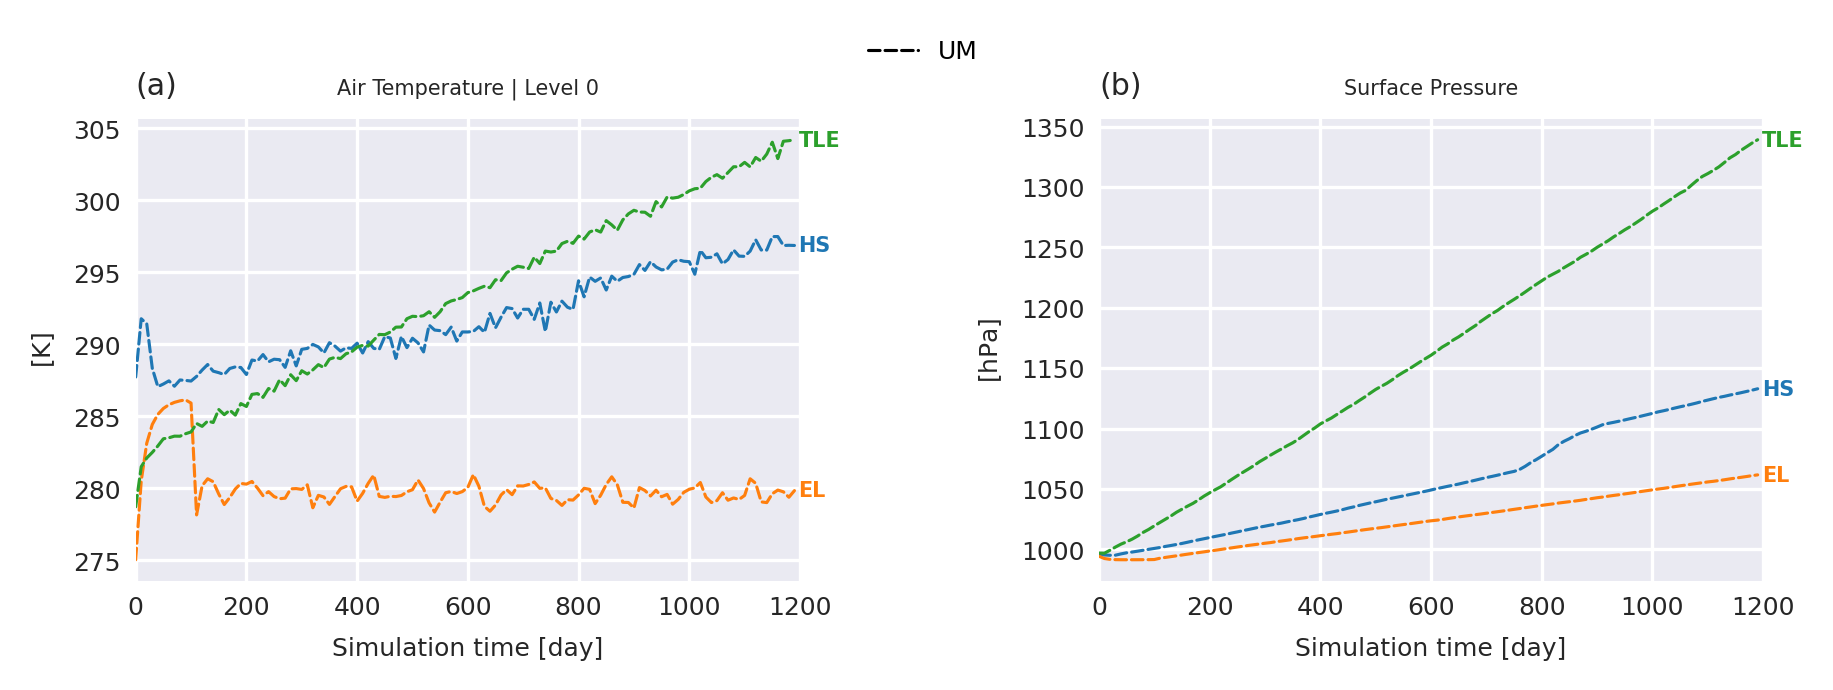

In [13]:
with plt.style.context("seaborn-v0_8-darkgrid"):
    fig = plt.figure(figsize=(7, 2))
    axd = fig.subplot_mosaic([DIAGS.keys()], gridspec_kw={"wspace": 0.45}, sharex=True)
    iletters = subplot_label_generator()
    for ax in axd.values():
        ax.set_title(f"({next(iletters)})", loc="left")

    model_key = "um"
    model_prop = MODELS[model_key]

    for diag_key, diag_prop in DIAGS.items():
        ax = axd[diag_key]
        ax.set_title(diag_prop["name"], size="small")
        # ax.set_ylim(diag_prop.get("lim"))
        ax.set_ylabel(f"[{diag_prop['tex_units']}]")
        ax.set_xlim(0, 1200)
        ax.set_xticks(np.arange(0, 1201, 200), dtype=int)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Simulation time [day]")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        for sim_label, sim_prop in SIM_CASES.items():
            cube = diag_prop["recipe"](runs[model_key][sim_label])
            cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
            days = get_cube_rel_days(cube)
            x = days
            y = cube.data
            ax.plot(x, y, **sim_prop["kw_plt"], **model_prop["kw_plt"])
            ax.annotate(
                text=sim_prop["short_title"],
                xy=(x[-1], y[-1]),
                xytext=(1, 0),
                textcoords="offset points",
                va="center",
                color=sim_prop["kw_plt"]["color"],
                fontsize="small",
                weight="bold",
            )
    add_custom_legend(
        fig,
        {v["title"]: {"color": "k", **v["kw_plt"]} for v in MODELS.values()},
        ncol=len(MODELS),
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05),
    )
    figsave(
        fig,
        paths.figures
        / f"exernal_forcing_{'_'.join(MODELS.keys())}_{'_'.join(SIM_CASES.keys())}_{'_'.join(DIAGS.keys())}",
    )